In [145]:
import pickle as pkl

import lxml
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.datasets import imdb


from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.utils.vis_utils import plot_model


from sklearn.metrics import roc_curve, roc_auc_score


import importlib
importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

In [2]:
tqdm.pandas()

In [3]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

In [4]:
import sys

In [5]:
!{sys.executable} -m list

/miniconda/bin/python: No module named list


### Get postive samples

In [53]:
drugbank = pkl.load(open('data/drugbank_embds.pkl', 'rb'))

In [54]:
drugbank['target_gene_code'] = drugbank['target_gene'].apply(lambda x: ''.join(list(x.split('\n')[1:])))
#drugbank['target_amino_code'] = drugbank['target_amino'].apply(lambda x: ''.join(list(x.split('\n')[1:])))

In [55]:
positive_samples_gene = pd.DataFrame()

positive_samples_gene['gene_id'] = drugbank['target_id'] 
positive_samples_gene['target_gene_code'] = drugbank['target_gene_code'] 

positive_samples_gene.to_pickle('positive_samples_gene.pkl')

In [56]:
gene_seq_list = drugbank['target_gene_code'].tolist()
gene_seq_len_list = []

for gene_name in gene_seq_list:
    gene_seq_len_list.append(len(gene_name))
    

Text(0,0.5,'Number of Genes')

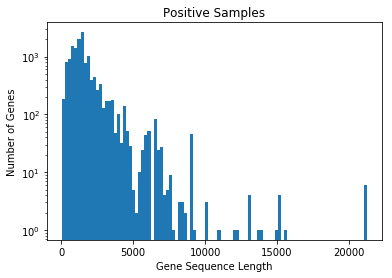

In [57]:
plt.hist(gene_seq_len_list, bins = 100, log = True)
plt.title('Positive Samples')
plt.xlabel('Gene Sequence Length')
plt.ylabel('Number of Genes')

In [58]:
with open ('data/chem_cid_SMILE_fngr_vector_fngr.pickle', 'rb') as f:
    smiles_df = pkl.load(f)
    
smiles_df['cid'] = smiles_df['cid'].astype(int)
drugbank = pd.merge(smiles_df, drugbank, right_on = 'pubchem_id', left_on = 'cid', how = 'right')

In [59]:
drugbank = drugbank[['drug_id', 'target_id', 'fingerprint', 'target_gene_code']]
drugbank = drugbank[~ drugbank['fingerprint'].isna()]
drugbank = drugbank.rename(columns = {'fingerprint': 'drug_fingerprint_code', 'target_id': 'gene_id'})

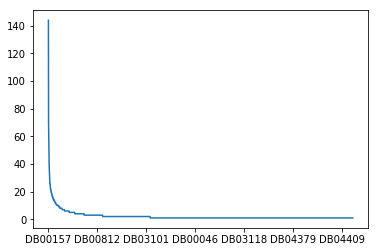

In [60]:
drugbank['drug_id'].value_counts().plot()

## NOTE: Why does NAD Bind to so many molecules?

In [61]:
drugbank[drugbank['drug_id'] == 'DB00157']

,drug_id,gene_id,drug_fingerprint_code,target_gene_code
7833,DB00157,BE0000645,2968968094 4140259565 3218693969 2070178920 32...,ATGTTTGAAATTAAGAAGATCTGTTGCATCGGTGCAGGCTATGTTG...
7834,DB00157,BE0000227,2968968094 4140259565 3218693969 2070178920 32...,ATGAGCACAGCAGGAAAAGTAATCAAATGCAAAGCAGCTGTGCTAT...
7835,DB00157,BE0000299,2968968094 4140259565 3218693969 2070178920 32...,ATGGCGGCGGCGGCCAAGCCCAACAACCTTTCCCTGGTGGTGCACG...
7836,DB00157,BE0000360,2968968094 4140259565 3218693969 2070178920 32...,ATGGGCACCAAGGGCAAAGTTATTAAATGCAAAGCAGCCATCGCCT...
7837,DB00157,BE0000465,2968968094 4140259565 3218693969 2070178920 32...,ATGAGCACAGCAGGAAAAGTAATCAAATGCAAAGCAGCTGTGCTAT...
...,...,...,...,...
7972,DB00157,BE0000096,2968968094 4140259565 3218693969 2070178920 32...,ATGCCAAGATGGTATTTTCTTTTGGCAAGATGCTTTGGTTGTGCAG...
7973,DB00157,BE0000735,2968968094 4140259565 3218693969 2070178920 32...,ATGGAGCGTCCGCAACCCGACAGCATGCCCCAGGATTTGTCAGAGG...
7974,DB00157,BE0000587,2968968094 4140259565 3218693969 2070178920 32...,ATGTCAGCGGAAGTGGAAACCTCAGAGGGGGTAGACGAGTCAGAAA...
7975,DB00157,BE0000344,2968968094 4140259565 3218693969 2070178920 32...,ATGTGGGAGCTCGTGGCTCTCTTGCTGCTTACCCTAGCTTATTTGT...


### Get DrugID -> Fingerprint mapping from positive samples

In [62]:
drug_map = drugbank[['drug_id', 'drug_fingerprint_code']].drop_duplicates('drug_id').set_index('drug_id')
target_map = drugbank[['gene_id', 'target_gene_code']].drop_duplicates('gene_id').set_index('gene_id')

In [63]:
negative_df = pd.read_csv('data/negative_samples_thrsh_12')[['node_0','node_1','shortest_path']] 
negative_df = negative_df.rename(columns = {'node_0': 'drug_id', 'node_1': 'gene_id'})
negative_df = negative_df[negative_df['drug_id'].str.contains('DB') & negative_df['gene_id'].str.contains('BE')]

In [64]:
negative_df = pd.merge(negative_df, drug_map, left_on = 'drug_id', right_index = True, how = 'left')
negative_df = pd.merge(negative_df, target_map, left_on = 'gene_id', right_index = True, how = 'left')

#### Note: Around 13% of negative samples don't match a drug id. Since the number is small, we ignore it for now

In [65]:
negative_samples_gene = pd.DataFrame()

negative_samples_gene['gene_id'] = negative_df['gene_id'] 
negative_samples_gene['target_gene_code'] = negative_df['target_gene_code'] 

#negative_samples_gene = negative_samples_gene.drop_duplicates(subset=['gene_id'], keep=False)

negative_samples_gene.to_pickle('negative_samples_gene.pkl')

In [66]:
len(negative_samples_gene)

411845

In [69]:
gene_seq_list = negative_df['target_gene_code'].tolist()
gene_seq_len_list = []

for gene_name in gene_seq_list:
    gene_seq_len_list.append(len(gene_name))

TypeError: object of type 'float' has no len()

/miniconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


Text(0,0.5,'Number of Genes')

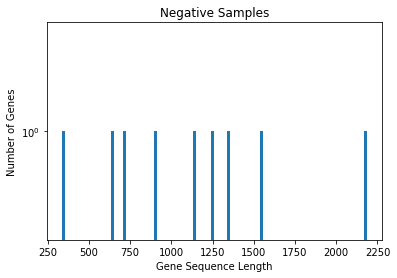

In [68]:
plt.hist(gene_seq_len_list, bins = 100, log = True)
plt.title('Negative Samples')
plt.xlabel('Gene Sequence Length')
plt.ylabel('Number of Genes')

In [70]:
len(negative_df[(negative_df['target_gene_code'].isna()) |
                (negative_df['drug_fingerprint_code'].isna())])/len(negative_df)

negative_df = negative_df[(~ negative_df['target_gene_code'].isna()) &
                (~ negative_df['drug_fingerprint_code'].isna())]

In [71]:
negative_df['Y'] = 0
drugbank['Y'] = 1
drugbank = drugbank.append(negative_df.sample(int(len(drugbank)*1.5))) ## NUMBER OF NEGATIVE SAMPLES TO PICK
drugbank = drugbank.drop('shortest_path', axis = 1)

In [72]:
drugbank[drugbank['target_gene_code'].str.contains('S').isna()]

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y


In [73]:
drugbank = drugbank[~ drugbank['drug_fingerprint_code'].str.contains('n')]

#### The dataset is clean and balanced

In [74]:
drugbank['Y'].value_counts()/len(drugbank)

0    0.599977
1    0.400023
Name: Y, dtype: float64

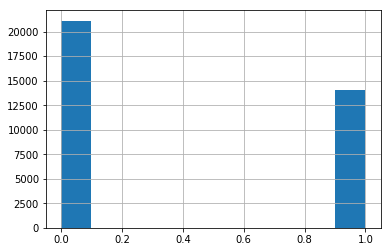

In [75]:
drugbank['Y'].hist()

#### Preprocessing fingerprints to feed to CNN

In [76]:
label_encoder = LabelEncoder()
label_encoder = pd.read_pickle('data/gene_encoder.pkl')
#label_encoder.fit(list(drugbank['target_gene_code'].iloc[0]))

#with open('data/gene_encoder.pkl', 'wb') as f:
#    pkl.dump(label_encoder, f)
    
gene_chars = set(list(drugbank['target_gene_code'].iloc[0]))

drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

#### Calculate length mismatches and pad

In [77]:
drugbank['target_gene_encoded_len'] = drugbank['target_gene_encoded']\
                                    .apply(lambda x: len(x))
drugbank['drug_fingerprint_encoded_len'] = drugbank['drug_fingerprint_encoded']\
                                    .apply(lambda x: len(x))

In [78]:
drugbank['mismatch'] = drugbank[['target_gene_encoded', 'drug_fingerprint_encoded']]\
                        .apply(lambda x: len(x['target_gene_encoded']) - len(x['drug_fingerprint_encoded']), axis = 1)

## Most Genes are longer than fingerprints

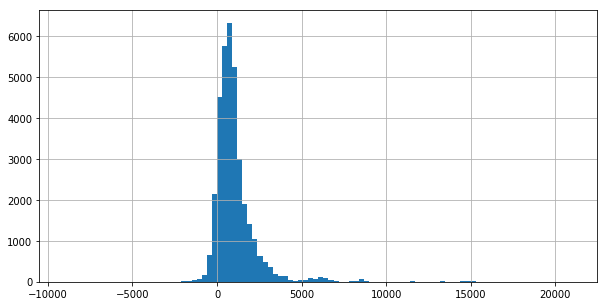

In [79]:
drugbank['mismatch'].hist(bins = 100, figsize = (10, 5))

In [80]:
print('95 percent of the mismatches are of the range %f to %f' % (max(drugbank['mismatch'].value_counts()) - np.std(drugbank['mismatch'].value_counts()),
                                                           max(drugbank['mismatch'].value_counts()) + np.std(drugbank['mismatch'].value_counts())))

95 percent of the mismatches are of the range 27.609643 to 42.390357


In [81]:
max_target_gene_encoded_len = max(drugbank['target_gene_encoded_len'])
max_drug_fingerprint_encoded_len = max(drugbank['drug_fingerprint_encoded_len'])

In [82]:
drugbank['target_gene_encoded_mismatch'] = max_target_gene_encoded_len - drugbank['target_gene_encoded_len']

In [83]:
drugbank['drug_fingerprint_encoded_mismatch'] = max_drug_fingerprint_encoded_len - drugbank['drug_fingerprint_encoded_len'] 

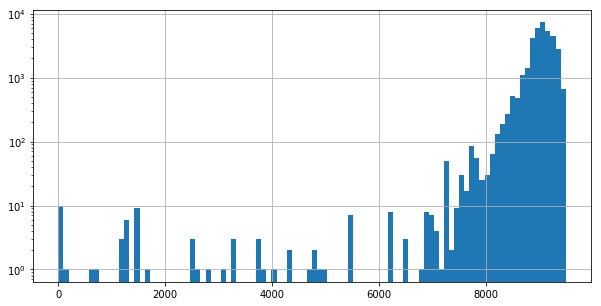

In [84]:
drugbank['drug_fingerprint_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

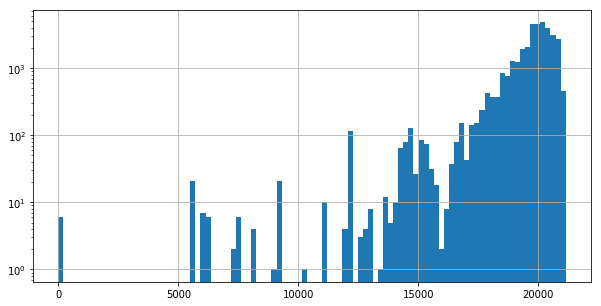

In [85]:
drugbank['target_gene_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

#### There appears to be quite large intracolumn mismatches in length. Unsure how to deal with it now. Current strategy is to pad the inputs and model it

In [86]:
drugbank['target_gene_encoded_padded'] = drugbank[['target_gene_encoded','target_gene_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['target_gene_encoded_mismatch']/2))] +   
                                                        list(x['target_gene_encoded']) +
                                                        ['-1' for i in range (int(x['target_gene_encoded_mismatch']/2))]
                                                        , axis = 1)
drugbank['target_gene_encoded_padded'] = drugbank['target_gene_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_target_gene_encoded_len else x)

In [87]:
drugbank['drug_fingerprint_encoded_padded'] = drugbank[['drug_fingerprint_encoded','drug_fingerprint_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['drug_fingerprint_encoded_mismatch']/2))] +   
                                                        list(x['drug_fingerprint_encoded']) +
                                                        ['-1' for i in range (int(x['drug_fingerprint_encoded_mismatch']/2))]
                                                        , axis = 1)

drugbank['drug_fingerprint_encoded_padded'] = drugbank['drug_fingerprint_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_drug_fingerprint_encoded_len else x)

In [88]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
0,DB03313,BE0001349,2246728737 3545365497 2246699815 2664995851 86...,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...,1,"[0, 3, 2, 2, 3, 1, 3, 1, 0, 2, 2, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",1221,547,674,20001,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,DB03313,BE0004335,2246728737 3545365497 2246699815 2664995851 86...,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...,1,"[0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2466,547,1919,18756,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,DB03313,BE0004290,2246728737 3545365497 2246699815 2664995851 86...,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...,1,"[0, 3, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2160,547,1613,19062,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,DB03313,BE0003624,2246728737 3545365497 2246699815 2664995851 86...,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...,1,"[0, 3, 2, 0, 2, 0, 1, 3, 2, 0, 3, 3, 3, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2058,547,1511,19164,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,DB03313,BE0004644,2246728737 3545365497 2246699815 2664995851 86...,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...,1,"[0, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2196,547,1649,19026,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517987,DB07700,BE0004651,2246728737 1861965050 2976816164 2677752761 29...,ATGGGTCAGAAAGTACATCCTAATGGTATTCGCCTGGGTATTGTAA...,0,"[0, 3, 2, 2, 2, 3, 1, 0, 2, 0, 0, 0, 2, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 1, 8, 6, 1, 9, ...",702,571,131,20520,8930,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
237808,DB03031,BE0001004,2246728737 3818546315 848128881 1914416804 224...,ATGGACCAAAATCAACATTTGAATAAAACAGCAGAGGCACAACCTT...,0,"[0, 3, 2, 2, 0, 1, 1, 0, 0, 0, 0, 3, 1, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 8, 1, 8, 5, ...",2076,735,1341,19146,8766,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
142511,DB02134,BE0003687,3218693969 584893129 2041434490 1100037548 321...,ATGACGCGTCCCCGATCCCCCCGTTCCCGTAACAGCAAAGCACGCC...,0,"[0, 3, 2, 0, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 0, ...","[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 5, 8, 4, 8, 9, ...",2325,212,2113,18897,9289,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1704541,DB04241,BE0004651,2246728737 422715066 3217380708 4033380444 204...,ATGGGTCAGAAAGTACATCCTAATGGTATTCGCCTGGGTATTGTAA...,0,"[0, 3, 2, 2, 2, 3, 1, 0, 2, 0, 0, 0, 2, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",702,427,275,20520,9074,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


## Building a CNN

In [50]:
drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

#drugbank = drugbank.sample(7500)

In [51]:
drugbank = drugbank_reader.__next__().drop('Unnamed: 0', axis = 1)
drugbank_test = drugbank_reader.__next__().drop('Unnamed: 0', axis = 1)

NameError: name 'drugbank_reader' is not defined

# Start from here - train only on gene sequence

In [4]:
#drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', converters={"target_gene_encoded_padded": \
#                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
#                                                                                    "drug_fingerprint_encoded_padded": \
#                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

In [5]:
drugbank

NameError: name 'drugbank' is not defined

In [ ]:
len(drugbank_reader)

In [49]:
drugbank = drugbank_reader.sample(7500, replace = False)
drugbank_test = drugbank_reader.sample(7500, replace = False)

In [44]:
train_df, test_df = train_test_split(drugbank)

In [49]:
train_df

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
410614,DB08313,BE0001167,2246728737 3975275337 864674487 2154935424 224...,ATGCCAAACTACAAACTCACTTATTTTAATATGAGGGGGAGAGCAG...,0,"[0, 3, 2, 1, 1, 0, 0, 0, 1, 3, 0, 1, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 9, 7, 5, 2, ...",600,409,191,20622,9092,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4688,DB07858,BE0003761,3218693969 951226070 3218693969 951226070 3217...,ATGTTCACCTTGGGATACCATGGGGCCGAGGAGTGGGCATCGGGCG...,1,"[0, 3, 2, 3, 3, 1, 0, 1, 1, 3, 3, 2, 2, 2, 0, ...","[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 5, 1, 2, 2, ...",1284,408,876,19938,9093,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
737477,DB00975,BE0004566,2968968094 2142032900 2968968094 2142032900 29...,ATGCCCAACGATGACTTCTGTCCTGGGCTAACCATAAAGGCCATGG...,0,"[0, 3, 2, 1, 1, 1, 0, 0, 1, 2, 0, 3, 2, 0, 1, ...","[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...",1770,708,1062,19452,8793,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
13561,DB01741,BE0001739,3218693969 98513984 3218693969 98513984 321869...,ATGAATCCACTCCTGATCCTTACCTTTGTGGCAGCTGCTCTTGCTG...,1,"[0, 3, 2, 0, 0, 3, 1, 1, 0, 1, 3, 1, 1, 3, 2, ...","[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",744,658,86,20478,8843,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
130613,DB08073,BE0000732,2246728737 422715066 3217380708 1308598964 321...,ATGGGGAAGGGGGTTGGACGTGATAAGTATGAGCCTGCAGCTGTTT...,0,"[0, 3, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 3, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",3072,583,2489,18150,8918,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338602,DB04432,BE0004743,2246728737 422715066 3217380708 3120642300 321...,ATGGTGGACCCGGTGGGCTTCGCGGAGGCGTGGAAGGCGCAGTTCC...,0,"[0, 3, 2, 2, 3, 2, 2, 0, 1, 1, 1, 2, 2, 3, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",3816,561,3255,17406,8940,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
12760,DB03059,BE0002684,2246728737 3545365497 2246699815 2080747022 86...,TTAGAAATAGCGCGGAAACGGGCTCCAGTCGGGGGGACGCTTCTGT...,1,"[3, 3, 0, 2, 0, 0, 0, 3, 0, 2, 1, 2, 1, 2, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",945,1043,-98,20277,8458,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
6029,DB07119,BE0000792,3218693969 951226070 3218693969 951226070 3217...,ATGGATATAAAAAACTCACCATCTAGCCTTAATTCTCCTTCCTCCT...,1,"[0, 3, 2, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 1, ...","[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 5, 1, 2, 2, ...",1488,365,1123,19734,9136,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
61918,DB00383,BE0002173,2246728737 3657471097 2092489639 1849554589 29...,TCTAAAATATGCAATTAAAACAGGGCATCCTAGATACTTCAATCAA...,0,"[3, 1, 3, 0, 0, 0, 0, 3, 0, 3, 2, 1, 0, 0, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 4, ...",1261,487,774,19961,9014,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


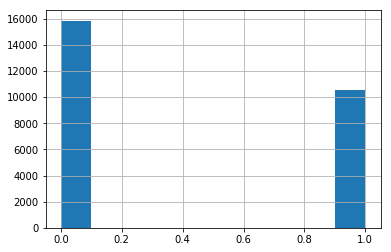

In [75]:
train_df['Y'].hist()

In [116]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
0,DB03313,BE0001349,2246728737 3545365497 2246699815 2664995851 86...,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...,1,"[0, 3, 2, 2, 3, 1, 3, 1, 0, 2, 2, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",1221,547,674,20001,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,DB03313,BE0004335,2246728737 3545365497 2246699815 2664995851 86...,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...,1,"[0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2466,547,1919,18756,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,DB03313,BE0004290,2246728737 3545365497 2246699815 2664995851 86...,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...,1,"[0, 3, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2160,547,1613,19062,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,DB03313,BE0003624,2246728737 3545365497 2246699815 2664995851 86...,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...,1,"[0, 3, 2, 0, 2, 0, 1, 3, 2, 0, 3, 3, 3, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2058,547,1511,19164,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,DB03313,BE0004644,2246728737 3545365497 2246699815 2664995851 86...,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...,1,"[0, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2196,547,1649,19026,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517987,DB07700,BE0004651,2246728737 1861965050 2976816164 2677752761 29...,ATGGGTCAGAAAGTACATCCTAATGGTATTCGCCTGGGTATTGTAA...,0,"[0, 3, 2, 2, 2, 3, 1, 0, 2, 0, 0, 0, 2, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 1, 8, 6, 1, 9, ...",702,571,131,20520,8930,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
237808,DB03031,BE0001004,2246728737 3818546315 848128881 1914416804 224...,ATGGACCAAAATCAACATTTGAATAAAACAGCAGAGGCACAACCTT...,0,"[0, 3, 2, 2, 0, 1, 1, 0, 0, 0, 0, 3, 1, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 8, 1, 8, 5, ...",2076,735,1341,19146,8766,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
142511,DB02134,BE0003687,3218693969 584893129 2041434490 1100037548 321...,ATGACGCGTCCCCGATCCCCCCGTTCCCGTAACAGCAAAGCACGCC...,0,"[0, 3, 2, 0, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 0, ...","[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 5, 8, 4, 8, 9, ...",2325,212,2113,18897,9289,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1704541,DB04241,BE0004651,2246728737 422715066 3217380708 4033380444 204...,ATGGGTCAGAAAGTACATCCTAATGGTATTCGCCTGGGTATTGTAA...,0,"[0, 3, 2, 2, 2, 3, 1, 0, 2, 0, 0, 0, 2, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",702,427,275,20520,9074,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


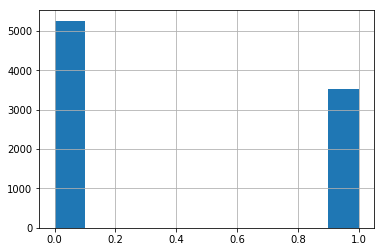

In [76]:
test_df['Y'].hist()

In [127]:
%%time
X_0 = np.array(list(drugbank['target_gene_encoded_padded'])).astype(int) + 1
X_1 = np.array(list(drugbank['drug_fingerprint_encoded_padded'])).astype(int) + 1
Y   = np.array(list(drugbank['Y'])).astype(int)

CPU times: user 15min 38s, sys: 17.4 s, total: 15min 55s
Wall time: 15min 43s


In [128]:
X_final = np.hstack((X_0, X_1))
#X_0_test = np.hstack((X_0_test, X_1_test))

In [129]:
target_length = 30723

X_final = X_final[:, (int(X_final.shape[1]/2) - int(target_length/2)):(int(X_final.shape[1]/2) + int(target_length/2)) + 1]

In [130]:
from tensorflow import keras

use_model = keras.models.load_model('models/CNN_GPU_VGG_rebalance.model')

In [138]:
Y_predicted = []

for X_0_chunck in tqdm(np.array_split(X_final,5000)): 
    
    #print(X_sub.shape)
    Y_predicted.extend(use_model.predict(X_0_chunck[..., np.newaxis]))
    

AttributeError: 'list' object has no attribute 'ravel'

In [141]:
Y_predicted = np.array(Y_predicted).ravel()

In [142]:
Y_predicted

array([9.92322147e-01, 9.76884067e-01, 6.49039298e-02, ...,
       1.22324382e-05, 7.20353186e-01, 1.16940625e-02], dtype=float32)

roc_auc_score:  0.7996401393652749


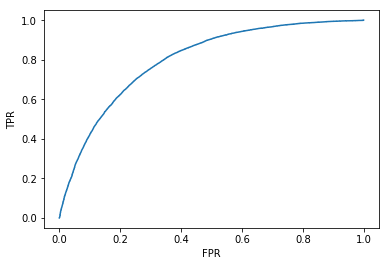

In [147]:
false_positive_rate, true_positive_rate, threshold = roc_curve(Y, Y_predicted)
print('roc_auc_score: ', roc_auc_score(Y, Y_predicted))
import matplotlib.pyplot as plt
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [53]:
X_0.shape

(26386, 2649)

In [54]:
X_0_test.shape

(8796, 2649)

In [55]:
del drugbank, drugbank_test, drugbank_reader

In [25]:
X_0.shape

(26390, 21222)

In [73]:
hidden_dims = 256
hidden_dims_2 = 256
hidden_dims_3 = 128
batch_size = 200
epochs = 3
model_optimizer = tensorflow.keras.optimizers.Nadam(lr=0.1, beta_1=0.8, beta_2=0.999)

model = Sequential()

#model.add(Dropout(0.2))
model.add(Conv1D(50000,
                 20,
                 strides=1,
                 activation='sigmoid'))


model.add(GlobalAveragePooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.0))
model.add(Activation('relu'))

model.add(GaussianNoise(hidden_dims))
model.add(Dropout(0.0))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_2))
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_3))
model.add(Dropout(0.0))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=model_optimizer,
              metrics=['binary_accuracy'])




model.fit(X_0_test[..., np.newaxis], Y_test,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_0_test[..., np.newaxis], Y_test))



Train on 8796 samples, validate on 8796 samples
Epoch 1/3
8796/8796 [==============================] - 31s 4ms/step - loss: 6.3449 - binary_accuracy: 0.5983 - val_loss: 6.4740 - val_binary_accuracy: 0.5983
Epoch 2/3
8796/8796 [==============================] - 28s 3ms/step - loss: 6.4740 - binary_accuracy: 0.5983 - val_loss: 6.4740 - val_binary_accuracy: 0.5983
Epoch 3/3
8796/8796 [==============================] - 27s 3ms/step - loss: 6.4740 - binary_accuracy: 0.5983 - val_loss: 6.4740 - val_binary_accuracy: 0.5983


In [58]:
model.save('data/models/pure_cnn_gene_only_TF1p6.model')

In [61]:
Y_pred = model.predict(X_0_test[..., np.newaxis])

In [63]:
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

In [64]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
cm = confusion_matrix(Y_test, Y_pred)

In [65]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[3482  188]
 [ 803 3027]]
Normalized confusion matrix
[[0.94877384 0.05122616]
 [0.20966057 0.79033943]]


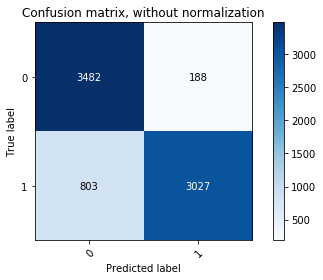

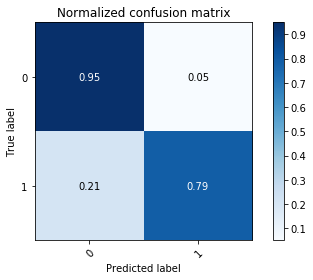

In [66]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [67]:
f1_score(Y_test, Y_pred)

0.8593328601845281

## CNN in Chunks

In [47]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.plot(range(len(global_val_history)), global_val_history, label = 'Accuracy - Global - Va;')
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [49]:
drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 1000, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

drugbank = drugbank_reader.__next__()



In [63]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
0,DB02704,BE0004010,2968968094 1824088295 2976033787 1228528465 29...,ATGCATTTAAATCCAGCAGAGAAAGAAAAATTACAAATTTTTCTAG...,0,[0 3 2 1 0 3 3 3 0 0 0 3 1 1 0 2 1 0 2 0 2 0 0...,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 1, 8, 2, 4, 0, ...",303,916,-613,20919,8585,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,DB06684,BE0001790,2968968094 2803848648 2968968094 2803848648 20...,ATGGAAATTAATGTGAGTAAATTAAGAACAGATTTGCCTCAAGTCG...,0,[0 3 2 2 0 0 0 3 3 0 0 3 2 3 2 0 2 3 0 0 0 3 3...,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 8, 0, 3, 8, ...",957,644,313,20265,8857,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,DB03811,BE0001167,3218693969 3777168895 3217380708 3585958780 21...,ATGCCAAACTACAAACTCACTTATTTTAATATGAGGGGGAGAGCAG...,0,[0 3 2 1 1 0 0 0 1 3 0 1 0 0 0 1 3 1 0 1 3 3 0...,"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 3, 7, 7, 7, 1, ...",600,195,405,20622,9306,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,DB02095,BE0004952,3218693969 98513984 3218693969 98513984 321869...,ATGATCATCTTAATTTACTTATTTCTCTTGCTATGGGAAGACACTC...,0,[0 3 2 0 3 1 0 3 1 3 3 0 0 3 3 3 0 1 3 3 0 3 3...,"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",834,207,627,20388,9294,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,DB03698,BE0002359,2246728737 3542456614 2245384272 1173125914 22...,ATGATGATGATGATGATGATGAAAAAAATGCAGCATCAACGGCAGC...,0,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",6546,1216,5330,14676,8285,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,DB00114,BE0001635,2246728737 422715066 3217380708 4033380444 204...,ATGAAGCTTTTAATTACCGGTGGATGTGGCTTCCTTGGGAGTAATC...,0,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",1017,309,708,20205,9192,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
996,DB04125,BE0000647,2246728737 3545365497 2246699815 2834566420 86...,ATGAGTAAGAGCAAATGCTCCGTGGGACTCATGTCTTCCGTGGTGG...,0,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",1863,693,1170,19359,8808,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
997,DB07090,BE0000339,2246728737 422715066 3217380708 3120642300 321...,ATGGTGATCCAGAAGTACATGCCTGGGGGCCTGTGTGGCTATGACC...,0,[0 3 2 2 3 2 0 3 1 1 0 2 0 0 2 3 0 1 0 3 2 1 1...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",972,450,522,20250,9051,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
998,DB07967,BE0001390,2968968094 2142032900 2968968094 2142032900 29...,ATGAGAATTGCGGTGATAGGTGGGGGAAGCAGCTACACCCCGGAGC...,0,[0 3 2 ... 3 2 0],"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...",1248,623,625,19974,8878,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [15]:
model_optimizer = tensorflow.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)
hidden_dims_3 = 32
batch_size = 2
epochs = 4
trim_width = 0
#train_df_all, test_df_all = train_test_split(drugbank)

In [8]:
def identity_block(X, kernel_size, filters):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    # Component 1
    X = Conv1D(filters = F1, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 2 
    X = Conv1D(filters = F2, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 3 
    X = Conv1D(filters = F3, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

In [9]:
def convolutional_block(X, kernel_size, filters, s = 2):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
#     X_shortcut = X
    
    ## Main Path 
#     print ("X In Conv : " + str(X.shape))
    # Component 1 
    X = Conv1D(filters = F1, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
#     print ("Component 1 : " + str(X.shape))
    
    # Component 2
    X = Conv1D(filters = F2, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
#     print ("Component 2 : " + str(X.shape))
    
    # Component 3
    X = Conv1D(filters = F3, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
#     print ("Component 3 : " + str(X.shape))
    
#     ## Shortcut Path
#     X_shortcut = Conv1D(filters = F3, kernel_size = 16, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X_shortcut)
#     X_shortcut = BatchNormalization()(X_shortcut)
#     print ("X Shortcut : " + str(X_shortcut.shape))
    
#     # Add Shortcut Path
#     X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
def ResNet_1D(input_shape = (30723, 1)):
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv1D(filters = 64, kernel_size = 16, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform())(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Stage 2 - 1 Conv Block & 2 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [64, 64, 128], s = 1)
    X = identity_block(X, kernel_size = 1, filters = [64, 64, 128])
    X = identity_block(X, kernel_size = 1, filters = [64, 64, 128])
    
    # Stage 3 - 1 Conv Block & 3 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    
    # Stage 4 - 1 Conv Block & 5 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    
    # Stage 5 - 1 Conv Block & 2 Identity Blocks 
    X = convolutional_block(X, kernel_size = 16, filters = [512, 512, 1024])
    X = identity_block(X, kernel_size = 1, filters = [512, 512, 1024])
    X = identity_block(X, kernel_size = 1, filters = [512, 512, 1024])
    
    
    X = GlobalAveragePooling1D()(X)
    X = Flatten()(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model
    

In [49]:
def VGG_16(input_shape = (30723, 1)):

    X_input = Input(input_shape)
    
    # Convolution Block 1
    X = Conv1D(filters = 64, kernel_size = 2, strides = 6, activation = 'relu')(X_input)
    X = Conv1D(filters = 64, kernel_size = 2, strides = 6, activation = 'relu')(X)
    X = BatchNormalization()(X)
    print (X.shape)
    X = AveragePooling1D()(X)
    print (X.shape)
    
    # Convolution Block 2
    X = Conv1D(filters = 128, kernel_size = 2, strides = 2, activation = 'relu')(X)
    X = Conv1D(filters = 128, kernel_size = 2, strides = 2, activation = 'relu')(X)
    X = BatchNormalization()(X)
    # Test Drop Out
    # X = Dropout(0.4)(X)

    # Convolution Block 3
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X)
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X)
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu')(X)
    X = BatchNormalization()(X)
    # Test Drop Out
    # X = Dropout(0.5)(X)

    # Convolution Block 4
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = BatchNormalization()(X)
    # Test Drop Out
    # X = Dropout(0.7)(X)

    # Convolution Block 5
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu')(X)
    #X = BatchNormalization()(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Flatten()(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)

    model = Model(inputs = X_input, outputs = X)

    return model

In [50]:
model = VGG_16()

(?, 854, 64)
(?, 427, 64)


In [11]:
model = ResNet_1D()

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30723, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15354, 64)    1088        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 15354, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 15354, 64)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

In [12]:
model.compile(loss = 'binary_crossentropy', optimizer = model_optimizer, metrics = ['binary_accuracy'])



In [13]:
drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 8, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


In [16]:
global_history = []
global_val_history = []

with open('data/gene_encoder.pkl', 'rb') as f:
    label_encoder = pkl.load(f)
    

for drugbank in tqdm(drugbank_reader):
    
    
    print('Reading chunk from file..')
    #drugbank = drugbank_reader.__next__()
    
    #drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
    #                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
    #drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

    
    print('Sampling..')
    train_df, test_df = train_test_split(drugbank)
    #train_df = train_df_all.sample(800)
    #test_df  = test_df_all.sample(800)
    
    print('Padding..') 
    X_0 = np.array(list(train_df['target_gene_encoded_padded']))
    X_1 = np.array(list(train_df['drug_fingerprint_encoded_padded']))
    Y   = np.array(list(train_df['Y']))
    

    X_0_test = np.array(list(test_df['target_gene_encoded_padded']))
    X_1_test = np.array(list(test_df['drug_fingerprint_encoded_padded']))
        
    Y_test   = np.array(list(test_df['Y']))
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)

    print('Trimming..')
    X_0 = X_0[:, int(trim_width/2) : X_0.shape[1] - int(trim_width/2)]
    X_1 = X_1[:, int(trim_width/2) : X_1.shape[1] - int(trim_width/2)]
    
    X_0_test = X_0_test[:, int(trim_width/2) : X_0_test.shape[1] - int(trim_width/2)]
    X_1_test = X_1_test[:, int(trim_width/2) : X_1_test.shape[1] - int(trim_width/2)]
    

    X_0 = X_0.astype(int) + 1
    X_1 = X_1.astype(int) + 1
    Y   = Y.astype(int)

    X_0_test = X_0_test.astype(int) + 1
    X_1_test = X_1_test.astype(int) + 1
    Y_test   = Y_test.astype(int)
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)


    X_0 = np.hstack((X_0, X_1))
    X_0_test = np.hstack((X_0_test, X_1_test))

    print('Modelling..')
    
    print("X0 Shape : " + str(X_0.shape))
    print("X1 Shape : " + str(X_1.shape))
    
    print("X0 Test Shape : " + str(X_0_test.shape))
    print("X1 Test Shape : " + str(X_1_test.shape))
    
    
    history = model.fit(X_0[..., np.newaxis], Y,
                          batch_size=batch_size,
                          epochs=1,
                          callbacks=[plot_losses],
                          validation_data=(X_0_test[..., np.newaxis], Y_test), verbose = 2)


    global_val_history.extend(history.history['val_binary_accuracy'])
    global_history.extend(history.history['binary_accuracy'])


    

Reading chunk from file..
Sampling..
Padding..
(6, 21222)
(6, 9501)
(2, 21222)
(2, 9501)
Trimming..
(6, 21222)
(6, 9501)
(2, 21222)
(2, 9501)
Modelling..
X0 Shape : (6, 30723)
X1 Shape : (6, 9501)
X0 Test Shape : (2, 30723)
X1 Test Shape : (2, 9501)
Train on 6 samples, validate on 2 samples
Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[128,64,1,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1d_3/conv1d/Conv2D}} = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/conv1d_3/conv1d/Conv2D_grad/Conv2DBackpropInput"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv1d_3/conv1d/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1d_3/conv1d/ExpandDims_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/activation_49_loss/broadcast_weights/assert_broadcastable/is_valid_shape/has_valid_nonscalar_shape/has_invalid_dims/concat/_2409}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_9526_...ims/concat", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


<Figure size 432x288 with 0 Axes>

In [ ]:
X_0_test.shape

In [71]:
model.save('models/CNN_GPU_VGG_87p.model')